In [1]:
import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import models
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import tensorflow as tf

In [2]:
_path = "D:\\amrita\\sem3\\introduction to AI and ML\\datasets\\dataset_fingerprint\\numpy_dataset"
x_real = np.load(rf"{_path}\\xReal.npz")
print(x_real.files)

['arr_0']


(6000, 90, 90, 1) (6000, 4)


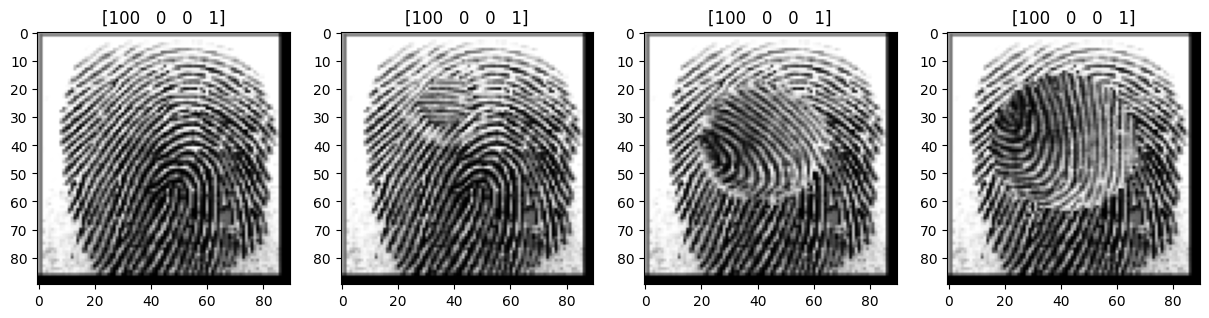

In [5]:
#dataset loader
_path = "D:\\amrita\\sem3\\introduction to AI and ML\\datasets\\dataset_fingerprint\\numpy_dataset"
x_real = np.load(rf"{_path}\xReal.npz")['arr_0']
y_real = np.load(rf"{_path}\yReal.npy")
x_easy = np.load(rf"{_path}\xEasy.npz")['arr_0']
y_easy = np.load(rf"{_path}\yEasy.npy")
x_medium = np.load(rf"{_path}\xMedium.npz")['arr_0']
y_medium = np.load(rf"{_path}\yMedium.npy")
x_hard = np.load(rf"{_path}\xHard.npz")['arr_0']
y_hard = np.load(rf"{_path}\yHard.npy")

print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')

In [6]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.1)

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

(49270, 90, 90, 1) (49270, 4)
(44343, 90, 90, 1) (44343, 4)
(4927, 90, 90, 1) (4927, 4)


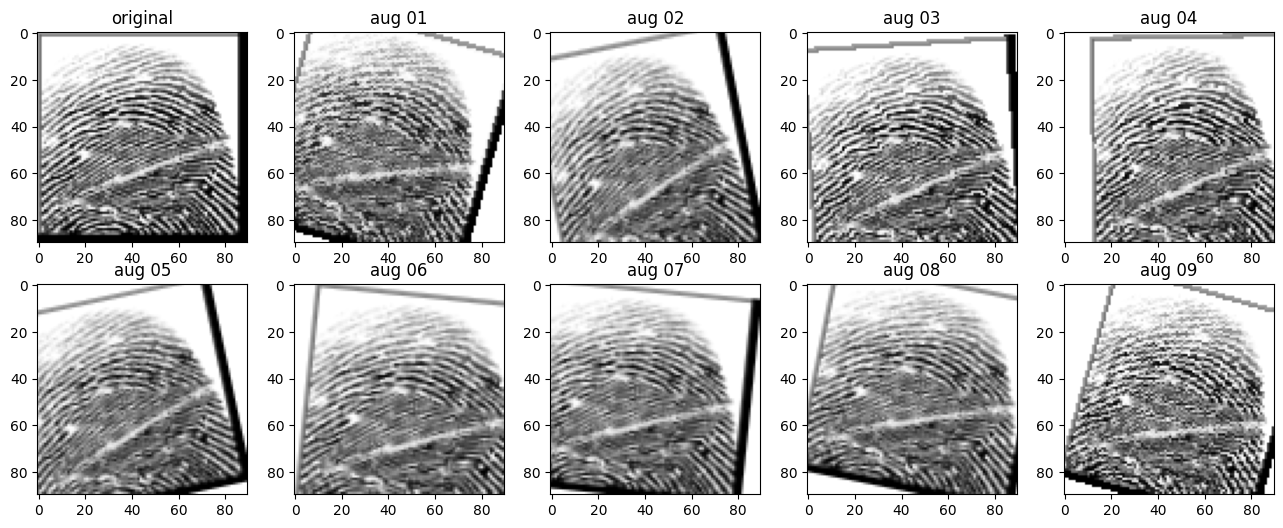

In [7]:
#sample augmentation

augs = [x_data[40000]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('original')
plt.imshow(x_data[40000].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

In [8]:
label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i

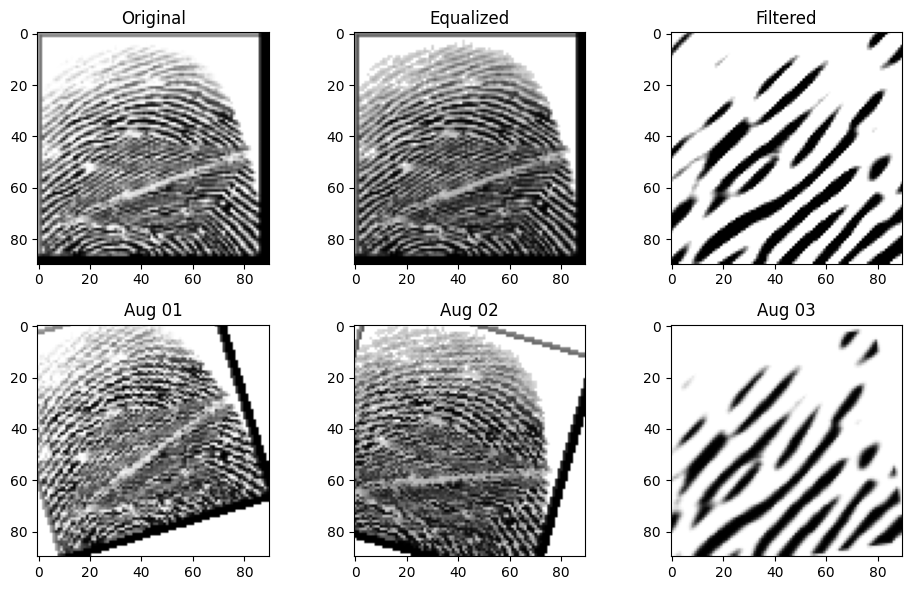

In [9]:
# Load the original image
original_image = x_data[40000]

# Apply histogram equalization to enhance contrast
equalized_image = cv.equalizeHist(original_image.squeeze())

# Define the parameters for Gabor filtering
ksize = (31, 31)  # Kernel size
sigma = 5.0  # Standard deviation of the Gaussian envelope
theta = np.pi / 4  # Orientation of the Gabor filter (45 degrees)
lambd = 10.0  # Wavelength of the sinusoidal factor
gamma = 0.5  # Spatial aspect ratio
psi = 0.0  # Phase offset

# Create the Gabor filter
gabor_kernel = cv.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi, ktype=cv.CV_32F)

# Apply Gabor filtering
filtered_image = cv.filter2D(equalized_image, cv.CV_8UC3, gabor_kernel)

# Create augmentation sequence
seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),  # Blur images with a sigma of 0 to 0.5
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},  # Scale images to 90-110% of their size, individually per axis
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},  # Translate by -10 to +10 percent (per axis)
        rotate=(-30, 30),  # Rotate by -30 to +30 degrees
        order=[0, 1],  # Use nearest neighbor or bilinear interpolation (fast)
        cval=255  # If mode is constant, use a cval between 0 and 255
    )
], random_order=True)

# Apply augmentation to the images
enhanced_augs = seq.augment_images([original_image, equalized_image, filtered_image])

# Plot the original and augmented images
plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('Original')
plt.imshow(original_image.squeeze(), cmap='gray')

plt.subplot(2, 5, 2)
plt.title('Equalized')
plt.imshow(equalized_image.squeeze(), cmap='gray')

plt.subplot(2, 5, 3)
plt.title('Filtered')
plt.imshow(filtered_image.squeeze(), cmap='gray')

for i, aug in enumerate(enhanced_augs):
    plt.subplot(2, 5, i+6)
    plt.title('Aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

plt.tight_layout()
plt.show()

In [10]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
            
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.
        # x1_batch = tf.convert_to_tensor(x1_batch / 255., dtype=tf.float32)
        # x2_batch = tf.convert_to_tensor(x2_batch / 255., dtype=tf.float32)
        # y_batch = tf.convert_to_tensor(y_batch, dtype=tf.float32)
        # print(f"x1_batch shape: {x1_batch.shape}, type: {type(x1_batch)}")
        # print(f"x2_batch shape: {x2_batch.shape}, type: {type(x2_batch)}")
        # print(f"y_batch shape: {y_batch.shape}, type: {type(y_batch)}")

        # return ((x1_batch, 
        #          x2_batch), 
        #         y_batch)
        return ((x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.), y_batch)

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [11]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

In [12]:
x1 = layers.Input(shape=(90, 90, 1))
x2 = layers.Input(shape=(90, 90, 1))

# share weights both inputs
inputs = layers.Input(shape=(90, 90, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = models.Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)

net = layers.Dense(64, activation='relu')(net)

net = layers.Dense(1, activation='sigmoid')(net)

model = models.Model(inputs=[x1, x2], outputs=net)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 90, 90, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 90, 90, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 22, 22,    │      9,568 │ input_layer[0][0… │
│ (Functional)        │ 32)               │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 22, 22,    │          0 │ functional[0][0], │
│                     │ 32)               │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 22, 22,    │      9,248 │ subtract[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 11, 11,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3872)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    247,872 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 266,753 (1.02 MB)

 Trainable params: 266,753 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(train_gen, epochs=2, validation_data=val_gen)

Epoch 1/2


c:\Users\Ravishankar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 198s 141ms/step - acc: 0.8453 - loss: 0.3177 - val_acc: 0.9851 - val_loss: 0.0772
Epoch 2/2
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 194s 140ms/step - acc: 0.9488 - loss: 0.1339 - val_acc: 0.9853 - val_loss: 0.0651


In [14]:
model.save('SNN_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


C:\Users\Ravishankar\AppData\Local\Temp\ipykernel_13020\2713637675.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('                    Matched Image: %.02f, %s' % (pred_rx, ry))


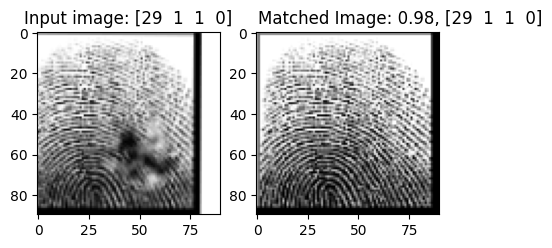

In [15]:
# new user fingerprint input
random_idx = random.randint(1, len(x_val))

random_img = x_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# unmatched image
# unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

# ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
# uy = y_real[unmatch_idx]

# pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input image: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('                    Matched Image: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
# plt.subplot(1, 3, 3)
# plt.title('X: %.02f, %s' % (pred_ux, uy))
# plt.imshow(ux.squeeze(), cmap='gray')

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[100   0   0   1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[100   0   0   4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
[100   0   0   2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[100   0   0   3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[100   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
[100   0   1   1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
[100   0   1   4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[100   0   1   2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[100   0   1   3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
[100   0   1   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[101   0   0   1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
[101   0   0   4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[101   0   0   2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
[101   0   0   3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
[101   0   0   0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[101   0   1   1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
[101   0   1   4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
[101   

C:\Users\Ravishankar\AppData\Local\Temp\ipykernel_13020\116030362.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('                    Matched Image: %.02f, %s' % (score, matched_label))


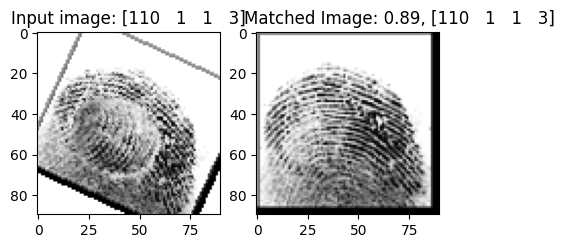

In [37]:
# new user fingerprint input
random_idx = 4000

random_img = x_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

# rx = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
# ry = y_real[label_real_dict[match_key]]

# pred_rx = model.predict([random_img, rx])

#predicting for every image in database and checking highest score
score = 0
index = 0
matched_image = None
matched_label = None
for i in range(150):
    if i % 100 == 0: print(i)
    pred_rx = model.predict([random_img, x_real[i].reshape((1, 90, 90, 1)).astype(np.float32) / 255.])
    print(y_real[i])
    if pred_rx > score:
        score = pred_rx
        index = i

matched_image = x_real[index]
matched_label = y_real[index]



# unmatched image
# unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

# ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
# uy = y_real[unmatch_idx]

# pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input image: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('                    Matched Image: %.02f, %s' % (score, matched_label))
plt.imshow(matched_image.squeeze(), cmap='gray')
# plt.subplot(1, 3, 3)
# plt.title('X: %.02f, %s' % (pred_ux, uy))
# plt.imshow(ux.squeeze(), cmap='gray')

In [35]:
label_val[3000]

array([121,   1,   1,   3], dtype=uint16)